In [73]:
import os
from IPython.display import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Image
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

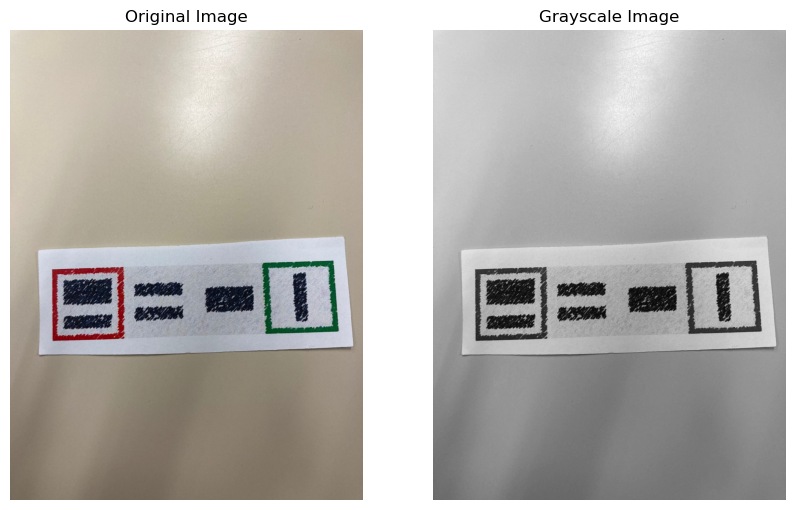

In [74]:
# Load the image
image = cv2.imread("img/ejemplo3.jpg")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)

# Display the images
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1); plt.imshow(image_rgb); plt.axis('off'); plt.title('Original Image')
plt.subplot(1, 2, 2); plt.imshow(image_gray, cmap='gray'); plt.axis('off'); plt.title('Grayscale Image')
plt.show()


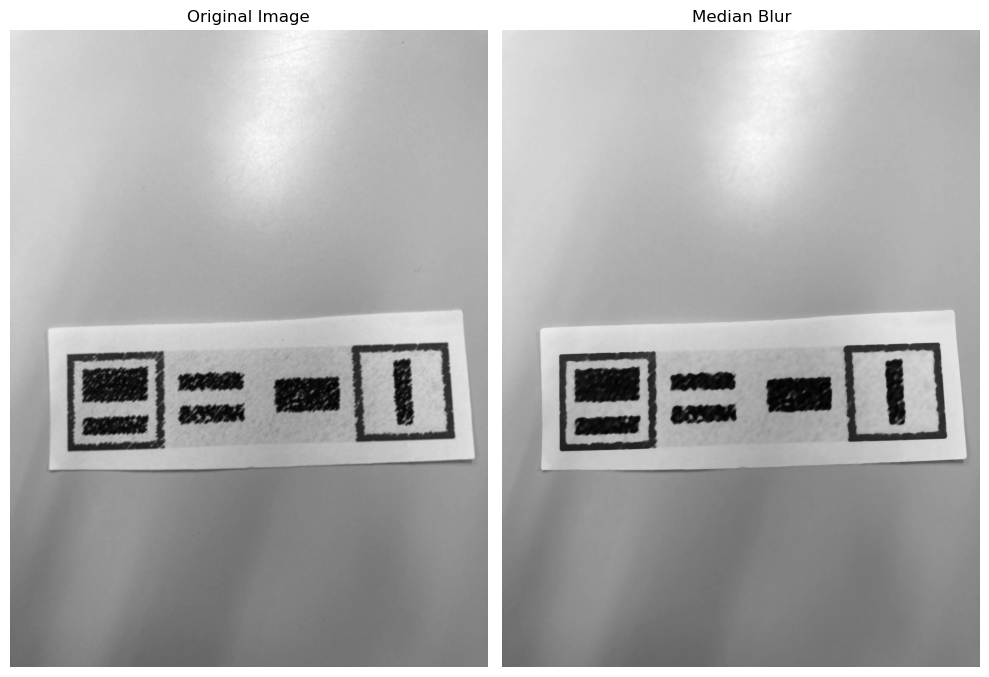

In [75]:
# Compare gaussian blur and median blur
image_blur_gaussian = cv2.GaussianBlur(image_gray, (11, 11), 0)
image_blur_median = cv2.medianBlur(image_gray, 11)


# Display the images
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1); plt.imshow(image_blur_gaussian, cmap='gray'); plt.axis('off'); plt.title('Original Image')
plt.subplot(1, 2, 2); plt.imshow(image_blur_median, cmap='gray'); plt.axis('off'); plt.title('Median Blur')
plt.tight_layout()
plt.show()

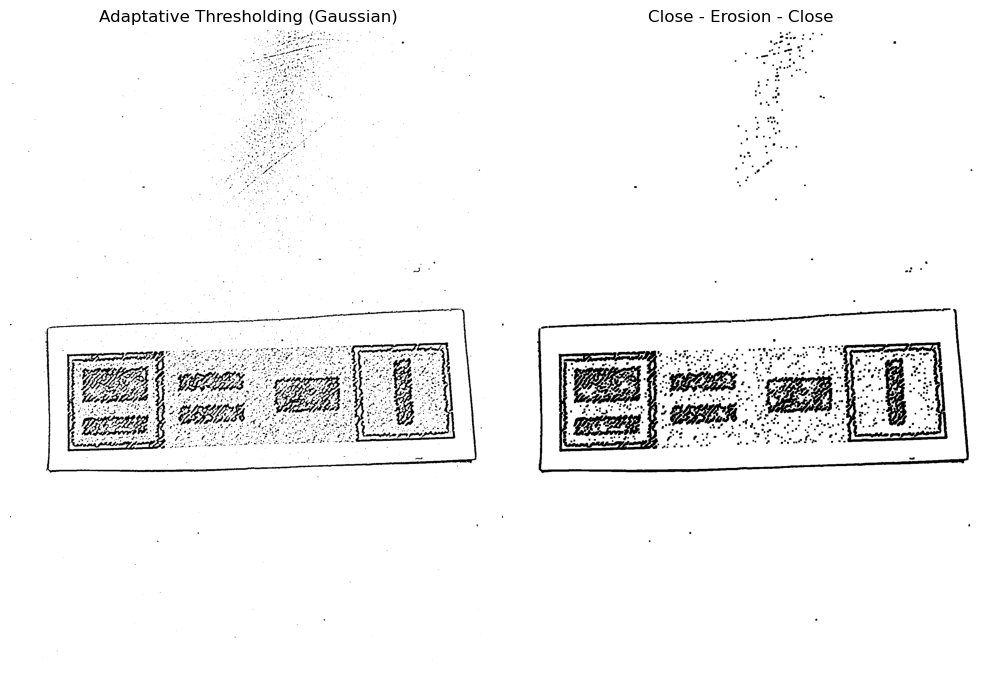

In [76]:
# Apply adaptive thresholding
threshold = 2
image_threshold_gaussian = cv2.adaptiveThreshold(image_blur_gaussian, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, threshold)
# _, imagen_umbralizada = cv2.threshold(image_blur_gaussian, 100, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
# To smooth the borders of the image, we can apply morphological operations such as erosion and dilation.
# Apply morphological operations
# kernel = np.ones((3, 3), np.uint8)
# image_erode = cv2.erode(image_threshold_gaussian, kernel, iterations=1)
# Suavizado de la imagen para borrar puntos (filtro de media 3x3)
# imagen_suavizada = cv2.medianBlur(imagen_umbralizada, 7)

# Cierre de la imagen
kernel = np.ones((3, 3), np.uint8)
imagen_cerrada = cv2.morphologyEx(image_threshold_gaussian,cv2.MORPH_CLOSE, kernel)
image_erode = cv2.erode(imagen_cerrada, kernel, iterations=1)
imagen_cerrada_2 = cv2.morphologyEx(image_erode,cv2.MORPH_CLOSE, kernel)
# Display the images
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1); plt.imshow(image_threshold_gaussian, cmap='gray'); plt.axis('off'); plt.title('Adaptative Thresholding (Gaussian)')
plt.subplot(1, 2, 2); plt.imshow(imagen_cerrada_2, cmap='gray'); plt.axis('off'); plt.title('Close - Erosion - Close')
plt.tight_layout()
plt.show()

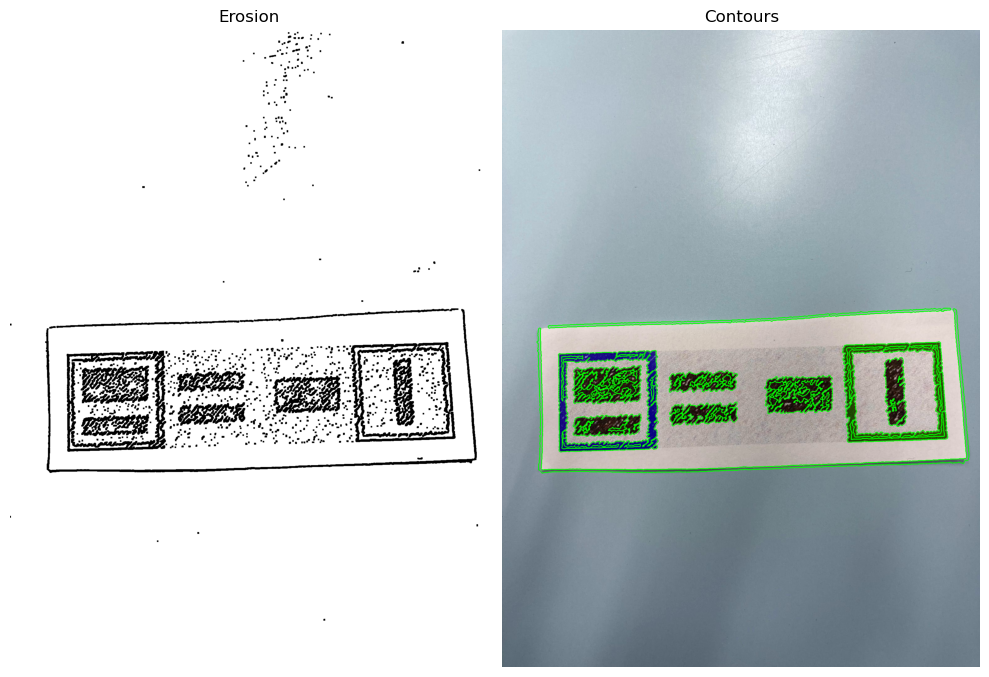

In [77]:
# Get the contours of the image
contours, _ = cv2.findContours(image_erode, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

# Function to filter contours by size and aspect ratio
def filter_contours(contours, min_size, max_size):
    filtered_contours = []
    for contour in contours:
        area = cv2.contourArea(contour)
        x, y, w, h = cv2.boundingRect(contour)
        if min_size <= area <= max_size:
            # If the contour is centered close to the border, ignore it
            if x > 15 and y > 15 and x + w < image_erode.shape[1] - 15 and y + h < image_erode.shape[0] - 15:
                filtered_contours.append(contour)
    return filtered_contours

# Get square contours
all_contours = filter_contours(contours, 200, 25000)

# Get square and rectangular contours
def segment_contours(contours, image_shape):
    square_contours = []
    rectangular_contours = []
    for contour in contours:
        area = cv2.contourArea(contour)
        area_ratio = area / (image_shape[0] * image_shape[1])
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = w / h
        if 0.6 <= aspect_ratio <= 1.5 and area_ratio > 0.06:
            square_contours.append(contour)
        else:
            rectangular_contours.append(contour)
    return square_contours, rectangular_contours

# Segment the contours
square_contours, rectangular_contours = segment_contours(all_contours, image_erode.shape)

# Function to filter contours that are inside other contours
def filter_inside_contours(contours):
    filtered_contours = []
    for contour in contours:
        parent_contour = None
        for other_contour in contours:
            if contour is not other_contour:
                # Verifica si todos los puntos están dentro del otro contorno
                if all(
                    cv2.pointPolygonTest(other_contour, (int(point[0][0]), int(point[0][1])), False) > 0
                    for point in contour
                ):
                    if parent_contour is None or cv2.contourArea(other_contour) > cv2.contourArea(parent_contour):
                        parent_contour = other_contour
        if parent_contour is None:
            filtered_contours.append(contour)
    return filtered_contours

# Filter the contours that are inside other contours
rectangular_contours = filter_inside_contours(rectangular_contours)

# Draw the contours on the image
image_contours_filter = np.copy(image)
for contour in rectangular_contours:
    cv2.drawContours(image_contours_filter, contour, -1, (0, 255, 0), 2)
for contour in square_contours:
    cv2.drawContours(image_contours_filter, contour, -1, (255, 0, 0), 2)

# Display the images
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1); plt.imshow(image_erode, cmap='gray'); plt.axis('off'); plt.title('Erosion')
plt.subplot(1, 2, 2); plt.imshow(image_contours_filter); plt.axis('off'); plt.title('Contours')
plt.tight_layout()
plt.show()

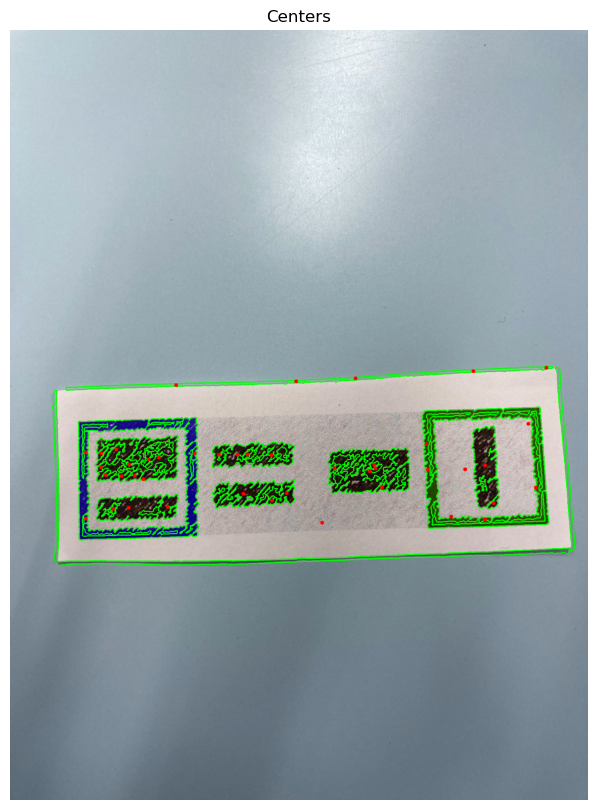

In [78]:
# Function to get the center of the contours 
def get_center(contours):
    centers = []
    for contour in contours:
        M = cv2.moments(contour)
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        centers.append((cX, cY))
    return centers

# Get the center of the contours
rectangular_centers = get_center(rectangular_contours)

# Draw the centers on the image_contours_filter
for center in rectangular_centers:
    cv2.circle(image_contours_filter, center, 5, (255, 0, 0), -1)

# Display the image
plt.figure(figsize=(10, 10))
plt.imshow(image_contours_filter)
plt.axis('off')
plt.title('Centers')
plt.show()


Segment 0: 13
Segment 1: 12
Segment 2: 9
Segment 3: 9


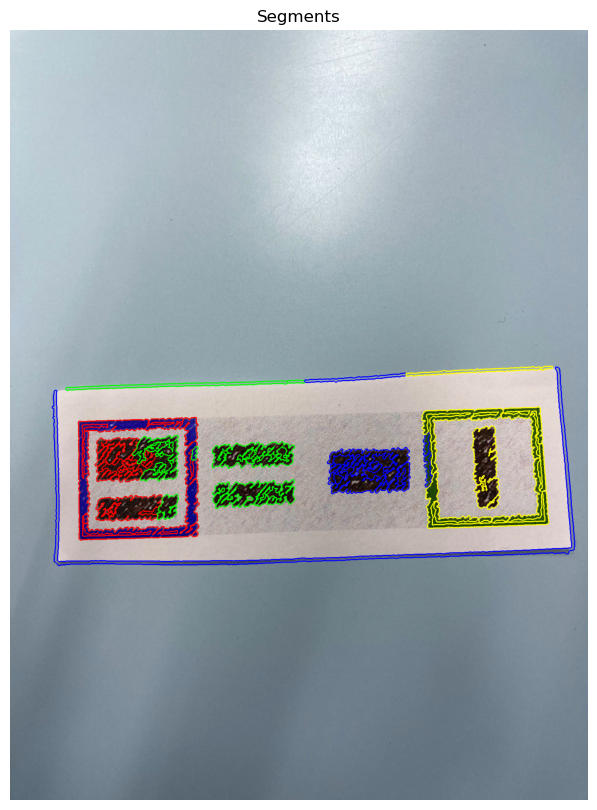

In [79]:
# Separate the contours in segments. The segments are defined by the x-coordinate of the center of the contours.
# We will use 4 segments. The width of the image will be divided into 4 equal parts. The contours will be assigned to the segment based on the x-coordinate of the center of the contours.
def separate_contours_by_segments(contours, image_width):
    segments = []
    for i in range(4):
        segments.append([])
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        center_x = x + w // 2
        segment = center_x // (image_width // 4)
        segments[segment].append(contour)
    return segments

# Separate the contours by segments
image_width = image.shape[1]
segments = separate_contours_by_segments(rectangular_contours, image_width)

# Draw the contours on the image
image_segments = np.copy(image)
colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0)]
for i, segment in enumerate(segments):
    for contour in segment:
        cv2.drawContours(image_segments, contour, -1, colors[i], 2)

# Count the number of contours in each segment
for i, segment in enumerate(segments):
    print(f'Segment {i}: {len(segment)}')
    
# Display the image
plt.figure(figsize=(10, 10))
plt.imshow(image_segments)
plt.axis('off')
plt.title('Segments')
plt.show()

In [80]:
# Estudiar la orientacion de los contornos para determinar si es horizontal o vertical
# Function to get the orientation of the contours
def get_orientation(contours):
    orientations = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if w > h:
            orientations.append('horizontal')
            # return 'Horizontal'
        else:
            orientations.append('vertical')
            # return 'Vertical'
    return orientations

# Get the orientation of the contours
rectangular_orientations = get_orientation(rectangular_contours)

# print  the orientation of the contours in each segment
for i, segment in enumerate(segments):
    orientations = get_orientation(segment)
    print(f'Segment {i}: {orientations}')


Segment 0: ['vertical', 'vertical', 'horizontal', 'horizontal', 'horizontal', 'horizontal', 'vertical', 'horizontal', 'vertical', 'vertical', 'horizontal', 'vertical', 'vertical']
Segment 1: ['horizontal', 'vertical', 'horizontal', 'vertical', 'vertical', 'vertical', 'vertical', 'horizontal', 'horizontal', 'vertical', 'horizontal', 'horizontal']
Segment 2: ['horizontal', 'horizontal', 'horizontal', 'horizontal', 'vertical', 'horizontal', 'vertical', 'horizontal', 'horizontal']
Segment 3: ['horizontal', 'horizontal', 'vertical', 'vertical', 'vertical', 'horizontal', 'vertical', 'horizontal', 'horizontal']


In [81]:
# Order the contours in each segment, if the sement has more than one contour. If both are horizontal,
# the contour with the smallest y-coordinate will be first. If both are vertical, the contour with the 
# smallest x-coordinate will be first. If more than tree contours give an error.
def order_contours(segments):
    ordered_segments = []
    for segment in segments:
        if len(segment) <= 1:
            ordered_segments.append(segment)
        elif len(segment) == 2:
            x1, y1, w1, h1 = cv2.boundingRect(segment[0])
            x2, y2, w2, h2 = cv2.boundingRect(segment[1])
            if w1 > h1 and w2 > h2:
                if y1 < y2:
                    ordered_segments.append([segment[0], segment[1]])
                else:
                    ordered_segments.append([segment[1], segment[0]])
            elif w1 < h1 and w2 < h2:
                if x1 < x2:
                    ordered_segments.append([segment[0], segment[1]])
                else:
                    ordered_segments.append([segment[1], segment[0]])
        else:
            ordered_segments.append(segment)
    return ordered_segments

# Order the contours in each segment
ordered_segments = order_contours(segments)

# Area ratio with respect to segment area, the area of the segment is defined as the area of the 
# image divided by 4. 
def get_area_ratio(contours, image):
    image_area = (image.shape[0] * image.shape[1]) / 4
    area_ratios = []
    for contour in contours:
        area = cv2.contourArea(contour)
        area_ratio = area / image_area
        area_ratios.append(round(area_ratio, 3))
    return area_ratios


# Get the area ratio of the contours
rectangular_area_ratio = get_area_ratio(rectangular_contours, image)

# Print the area ratio of the contours in each segment
for i, segment in enumerate(ordered_segments):
    area_ratio = get_area_ratio(segment, image)
    print(f'Segment {i}: {area_ratio}')

Segment 0: [0.0, 0.0, 0.011, 0.001, 0.001, 0.001, 0.0, 0.001, 0.001, 0.0, 0.006, 0.002, 0.032]
Segment 1: [0.0, 0.003, 0.01, 0.002, 0.0, 0.0, 0.002, 0.004, 0.006, 0.009, 0.005, 0.0]
Segment 2: [0.001, 0.0, 0.0, 0.0, 0.001, 0.02, 0.001, 0.002, 0.025]
Segment 3: [0.0, 0.002, 0.001, 0.005, 0.014, 0.016, 0.005, 0.003, 0.0]


In [82]:
# Compute the relation between the area contour on every segment
for i, segment in enumerate(ordered_segments):
    if len(segment) == 2:
        area1 = cv2.contourArea(segment[0])
        area2 = cv2.contourArea(segment[1])
        area_ratio = round(area1 / area2, 3)
        print(f'Segment {i}: {area_ratio}')



In [83]:
# Function to order the information of the segments. Number of contours, orientation, area ratio,
# and relation between the area of the contours.
def get_segment_info(contours, image):
    segments = []
    for i in range(4):
        segments.append([])
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        center_x = x + w // 2
        segment = center_x // (image.shape[1] // 4)
        segments[segment].append(contour)
    # Order the contours in each segment
    ordered_segments = order_contours(segments)
    # Get the orientation of the contours
    orientations = []
    for i in range(4):
        orientations.append(get_orientation(ordered_segments[i]))

    # Get the area ratio of the contours
    area_ratios = []
    for i in range(4):
        area_ratios.append(get_area_ratio(ordered_segments[i], image))
        
    # Get the relation between the area of the contours
    area_ratios_relation = []
    for i, segment in enumerate(ordered_segments):
        if len(segment) == 2:
            area1 = cv2.contourArea(segment[0])
            area2 = cv2.contourArea(segment[1])
            area_ratio = round(area1 / area2, 3)
            area_ratios_relation.append(area_ratio)
        else:
            area_ratios_relation.append(None)

    # Get the information of the segments
    segment_info = []
    for i in range(4):
        segment_info.append({'num_contours': len(ordered_segments[i]), 'orientation': orientations[i], 'area_ratios': area_ratios[i], 'area_ratios_relation': area_ratios_relation[i]})
    return segment_info

# Get the information of the segments
segment_info = get_segment_info(rectangular_contours, image)

# Print the information of the segments
for i in range(4):
    print(f'Segment {i+1}:')
    print(f'Number of contours: {segment_info[i]["num_contours"]}')
    print(f'Orientation: {segment_info[i]["orientation"]}')
    print(f'Area ratio: {segment_info[i]["area_ratios"]}')
    print(f'Area ratio relation: {segment_info[i]["area_ratios_relation"]}')
    print()
    
        
    

Segment 1:
Number of contours: 13
Orientation: ['vertical', 'vertical', 'horizontal', 'horizontal', 'horizontal', 'horizontal', 'vertical', 'horizontal', 'vertical', 'vertical', 'horizontal', 'vertical', 'vertical']
Area ratio: [0.0, 0.0, 0.011, 0.001, 0.001, 0.001, 0.0, 0.001, 0.001, 0.0, 0.006, 0.002, 0.032]
Area ratio relation: None

Segment 2:
Number of contours: 12
Orientation: ['horizontal', 'vertical', 'horizontal', 'vertical', 'vertical', 'vertical', 'vertical', 'horizontal', 'horizontal', 'vertical', 'horizontal', 'horizontal']
Area ratio: [0.0, 0.003, 0.01, 0.002, 0.0, 0.0, 0.002, 0.004, 0.006, 0.009, 0.005, 0.0]
Area ratio relation: None

Segment 3:
Number of contours: 9
Orientation: ['horizontal', 'horizontal', 'horizontal', 'horizontal', 'vertical', 'horizontal', 'vertical', 'horizontal', 'horizontal']
Area ratio: [0.001, 0.0, 0.0, 0.0, 0.001, 0.02, 0.001, 0.002, 0.025]
Area ratio relation: None

Segment 4:
Number of contours: 9
Orientation: ['horizontal', 'horizontal', 'v

In [84]:
# Decode segment number given the information of the segments
def decode_number(segment_info):
    segment_number = ''
    for i in range(4):
        num_contours = segment_info[i]['num_contours']
        orientation = segment_info[i]['orientation']
        area_ratios = segment_info[i]['area_ratios']
        area_ratios_relation = segment_info[i]['area_ratios_relation']
        if num_contours == 0:
            segment_number += '0'
        elif num_contours == 1:
            if orientation[0] == 'horizontal':
                segment_number += '8'
            else:
                if area_ratios[0] < 0.11:
                    segment_number += '1'
                else:
                    segment_number += '5'
        elif num_contours == 2:
            if orientation[0] == 'horizontal':
                if area_ratios_relation > 1.2:
                    segment_number += '7'
                elif area_ratios_relation < 0.85:
                    segment_number += '9'
                else:
                    segment_number += '3'
            else:
                if area_ratios_relation > 1.2:
                    segment_number += '6'
                elif area_ratios_relation < 0.85:
                    segment_number += '4'
                else:
                    segment_number += '2'
        else:
            segment_number += 'x'
    return segment_number

# Decode the segment number
segment_number = decode_number(segment_info)
print(f'Segment number: {segment_number}')

Segment number: xxxx
